# Progetto EIM - Codice testing
Brenciani - Filippi - Marini - Mengoni

# inizializzazione workspace

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0 
!pip install plotly==5.3.1
!pip install imagecodecs
# !pip install histomicstk --find-links https://girder.github.io/large_image_wheels

     |████████████████████████████████| 421.8 MB 27 kB/s 
     |████████████████████████████████| 3.8 MB 41.4 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 448 kB 29.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=3b13b7d489c9bb337c9207b69cf8a113ce281978fb2c554a04a5f590331b20d2
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [3]:
import os
import random
import numpy as np
import plotly.express as px
import plotly.express as px

import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
import skimage 
from skimage import exposure
from scipy import ndimage
import scipy as sp
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from segmentation_models import Unet

from skimage.color import gray2rgb
from skimage.color import rgb2gray
import imagecodecs

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


# funzioni per validazione test


### funzioni per prestazioni

In [4]:
def IoU(im1, im2, empty_score=1.0):

    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
         return empty_score

    union = np.logical_or(im1, im2)
    if union.sum() == 0:
        return empty_score

    intersection = np.logical_and(im1, im2)

    return (intersection.sum() / union.sum() )


In [5]:
def precision(im1, im2,empty_score=1.0):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()  
    if im_sum == 0:
         return empty_score

    im_sum2 = im2.sum()
    if im_sum2 == 0:
         return 0

    intersection = np.logical_and(im1, im2)

    return (intersection.sum() / im2.sum() )


In [6]:
def recall(im1, im2,empty_score=1.0):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
         return empty_score
    im_sum2 = im1.sum()
    if im_sum2 == 0:
         return 0

    intersection = np.logical_and(im1, im2)

    return (intersection.sum() / im1.sum() )


In [7]:
def dice_coeff(im1, im2, empty_score=1.0): # dice o f1 score

    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() / im_sum)


### postprocessing e sovrapposizione

[opening and closing](https://www.geeksforgeeks.org/difference-between-opening-and-closing-in-digital-image-processing/)

[domcumentazione skimage](https://scikit-image.org/docs/stable/api/api.html)


In [8]:
def postprocessing(canale):
    # chiusura
    footprint = skimage.morphology.disk(3,dtype= bool)
    canale=sp.ndimage.binary_dilation(canale, footprint)
    footprint = skimage.morphology.disk(3,dtype= bool)
    canale=sp.ndimage.binary_erosion(canale, footprint)


    #rimozione piccoli oggetti
    from skimage import morphology
    canale = morphology.remove_small_objects(canale, min_size=80, connectivity= 1)
    canale = morphology.remove_small_holes(canale, area_threshold=80, connectivity=1)


    return canale

In [9]:
#gestione delle sovrapposizioni tra le maschere
def sovrapposizione(mask):

  #citoplasma e sfondo 
  l = 0 #livello da azzerare
  mask_sc = np.add(mask[:,:,0],mask[:,:,1])
  indici = np.where(mask_sc == 2)

  mask_temp = mask[:,:,l];
  mask_temp[indici] = 0;
  mask[:,:,l] = mask_temp; 

  #sfondo e nucleo 
  l = 0 #livello da azzerare
  mask_sc = np.add(mask[:,:,0],mask[:,:,2])
  indici = np.where(mask_sc == 2)

  mask_temp = mask[:,:,l];
  mask_temp[indici] = 0;
  mask[:,:,l] = mask_temp; 

  #citoplasma e nucleo 
  l = 1 #livello da azzerare
  mask_sc = np.add(mask[:,:,1],mask[:,:,2])
  indici = np.where(mask_sc == 2)

  mask_temp = mask[:,:,l]; 
  mask_temp[indici] = 0; 
  mask[:,:,l] = mask_temp; 

  # #mette come sfondo tutte le parti vuote (nere) e li sostituisce con lo sfondo 
  l = 0 #livello in questo con cui vengono riempiti i buchi
  mask_sc = mask[:,:,0]+mask[:,:,1]+mask[:,:,2]
  [indici1,indici2] = np.where(mask_sc == 0)
  
  mask_temp = np.zeros(mask[:,:,l].shape); #copia livello da modificare
  mask_temp[indici1,indici2] = 1; #assegna gli indici allo sfondo
  mask[:,:,l]=mask_temp + mask[:,:,l]
  return mask

### main funzione di validazione

In [10]:
# usato per il test set senza maschere
def validazione_test(X):

  from skimage import img_as_bool
  from skimage import img_as_float

  mask_auto_pv = np.zeros((X.shape[0],fs,fs,3), dtype = np.float32)
  IoUval = np.zeros((X.shape[0],4))

  for n in range(X.shape[0]):

    image = X[n,:,:,:]

    img = np.reshape(image,(1,fs,fs,3))
    softmax = model.predict(img)
    softmax = np.reshape(softmax,(fs,fs,3))

    threshold1 = 0.5
    threshold2 = 0.1
    threshold3 = 0.2

    canale1 = softmax[:,:,0]
    canale2 = softmax[:,:,1]
    canale3 = softmax[:,:,2]

    canale1[canale1<=threshold1]=0
    canale1[canale1>threshold1]=1
    canale1 = img_as_bool(canale1)
    canale1 = postprocessing(canale1)

    canale2[canale2<=threshold2]=0
    canale2[canale2>threshold2]=1
    canale2 = img_as_bool(canale2) 
    canale2 = postprocessing(canale2)

    canale3[canale3<=threshold3]=0
    canale3[canale3>threshold3]=1
    canale3=img_as_bool(canale3)
    canale3 = postprocessing(canale3)

    mask_temp = img_as_float(np.stack((canale1,canale2,canale3), axis=-1))
    mask_temp = sovrapposizione(mask_temp)

    mask_auto_pv[n,:,:,:] = mask_temp

  return mask_auto_pv

### watershed


[watershed wikipedia](https://en.wikipedia.org/wiki/Watershed_(image_processing))

[watershed di skimage](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html)

[esempio interessante](
https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py)

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
from skimage import img_as_ubyte,img_as_bool
from google.colab.patches import cv2_imshow

def watershed_function(mask_auto_pv,X, *k):
    try:
      k = k[0]
    except:
      k = 1
    k = k-1 # perchè gli indici partono da 0

    ncount=0
    markers_cells = np.zeros((X.shape[0],fs,fs))

    for n in range(X.shape[0]):

      img=mask_auto_pv[n,:,:,:] #maschera corrente
      cells=img[:,:,2]+img[:,:,1] #sommo maschera nuclei e citoplasmi

      img=img_as_ubyte(img)
      cells=img_as_ubyte(cells)
      kernel = np.ones((3,3),np.uint8)

      sure_bg = cv2.dilate(cells,kernel,iterations=2)
      
      dist_transform = cv2.distanceTransform(img[:,:,2],cv2.DIST_L2,5) # distance transform del nucleo
      ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
      sure_fg = np.uint8(sure_fg)

      unknown = cv2.subtract(sure_bg,sure_fg)
      ret3, markers = cv2.connectedComponents(sure_fg)

      ncount = ncount + markers.max()+1
      markers = markers+10
      markers[unknown==255] = 0

      markers = cv2.watershed(img_as_ubyte(np.stack((cells,cells,cells),axis = -1)),markers)
      img[markers == -1] = [0,255,255]  

      img2 = color.label2rgb(markers, bg_label=0)

      markers_cells[n,:,:]=markers

      if n == k:
        fig = plt.figure(figsize=(40,20))
        ax0 = fig.add_subplot(1,8,4)
        ax0.imshow(sure_bg,cmap=plt.cm.gray), ax0.set_title('sure_bg')
        ax1 = fig.add_subplot(1,8,5)
        ax1.imshow(dist_transform,cmap=plt.cm.gray), ax1.set_title('dist_transform')
        ax2 = plt.subplot(1,8,6)
        ax2.imshow(sure_fg)
        ax2.set_title('sure_fg')
        ax3 = plt.subplot(1,8,7)
        ax3.imshow(unknown)
        ax3.set_title('unknown')

        ax0 = fig.add_subplot(1,8,3)
        ax0.imshow(cells,cmap=plt.cm.gray), ax0.set_title('cell mask')
        ax1 = fig.add_subplot(1,8,2)
        ax1.imshow(mask_auto_pv[n,:,:,:],cmap=plt.cm.gray), ax1.set_title(f"automatic mask number {k+1}")
        ax2 = plt.subplot(1,8,1)
        ax2.set_title('original image')
        ax2.imshow(X[n,:,:,:])
        ax3 = plt.subplot(1,8,8)
        ax3.imshow(img2)
        ax3.set_title('watershed segmentation')
    return markers_cells,ncount

### mask to greyscale e mask creation

funzioni per salvataggio maschere

In [12]:
def mask_to_grayscale(mask):

  mask_greyscale = np.zeros((fs,fs),dtype = np.uint8)
  mask_greyscale[mask[:,:,0] == 1] = 0
  mask_greyscale[mask[:,:,1] == 1] = 128
  mask_greyscale[mask[:,:,2] == 1] = 255

  return mask_greyscale

In [13]:
# mask cell sono le maschere con le cellule singole
# mask auto le maschere nromali 
def mask_creation(markers_cells,mask_auto_pv,X,*N_cells):
  try: 
    N_cells = N_cells[0]
  except:
    pass

  mask_cell_greyscale = [] 

  for n in range(0,X.shape[0]): 
    seq = np.array(range(10, int(np.max(markers_cells[n])+1))) #vettore classi (si parte da 10) es: seq=10 11 12 13 14 15 (6 segmentazioni)

    mask_cell=np.zeros((np.max(seq)-9,fs,fs)) # numero maschere cellule creato in base al numero di classi (1 canale, maschera binaria) [num=6=0..5] 
    #print(f"{mask_cell.shape[0]}:{np.max(seq)}")
    mask_cell_final=np.zeros((fs,fs,mask_cell.shape[0]-1), dtype = np.uint8)

    for i in range(1,mask_cell.shape[0]): # [1..5], escludo la prima maschera (0) che è lo sfondo!
        mask_cell_temp=np.zeros((fs,fs,3), dtype = np.uint8)
        k=seq[i]
        x,y=np.where(markers_cells[n]==k) #trova i punti appartenenti a quella classe(la prima è 11)
        mask_cell_temp[x,y,:]=mask_auto_pv[n,x,y,:]  # matrice globale contenente tutte le segmentazioni di tutte le cellule di tutto il train
        mask_cell_final[:,:,i-1] = mask_to_grayscale(mask_cell_temp)

    try:
      print(f"{n+1} : sono state trovate {mask_cell_final.shape[2]} cellule su {N_cells[n]}")
    except:
      print(f"{n+1} : sono state trovate {mask_cell_final.shape[2]} cellule")

    mask_cell_greyscale.append(mask_cell_final)

  return mask_cell_greyscale




# caricamento modello

In [41]:
model = load_model('/content/drive/MyDrive/EIM laboratori/progetto/rete')

# Test

### costruzione testset e caricamento dati

In [14]:
# carica la cartella
dataset_name = '/content/drive/MyDrive/EIM laboratori/progetto/DATASET'

# Path
TEST_IMG_path = os.path.join(dataset_name,'test','images')
TEST_AUTO_path = os.path.join(dataset_name,'test','automatic')

# Estrazione della lista di volumi del training e validation set
test_images = os.listdir(TEST_IMG_path)

NUM_CLASSES = 3
# Inizializzazioni matrici
prop = 2040/1536

dim1 = 512
dim2 = round(dim1*prop)

a = np.zeros((2,100))


In [17]:
#TEST IMAGES
X_test =  np.zeros((len(test_images),dim1,dim2,3), dtype=np.uint8)
size_test = np.zeros((len(test_images),2))

for n, id in tqdm(enumerate(test_images), total=len(test_images)):

    img = imread(TEST_IMG_path + '/' + id)
    size_test[n] = img.shape[0:1]
    img = resize(img,(dim1,dim2), preserve_range=True )
    X_test[n] = img
    

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


#### Preprocessing

In [18]:
fs = 256

def preprocessing(image):
  image = resize(image,(fs,fs), preserve_range = True)
  
  return image

In [20]:
# preprocessing test images
X_test_processed = np.zeros((X_test.shape[0],fs,fs,3), dtype=np.uint8)


for i in tqdm(range(X_test.shape[0])):
    image = X_test[i,:,:,:]
    l1 = preprocessing(image[:,:,0])
    l2 = preprocessing(image[:,:,1])
    l3 = preprocessing(image[:,:,2])
    X_test_processed[i,:,:,:] = np.stack((l1,l2,l3), axis=-1)

100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


### Validazione

In [ ]:
# con immagini test
print('TEST SET')
mask_auto_test = validazione_test(X_test_processed)    
[markers_cells_test,ncount_test] = watershed_function(mask_auto_test,X_test_processed,49)        

mask_cell_greyscale_test   = mask_creation(markers_cells_test,mask_auto_test,X_test_processed)
    
tot_cell_test = 0
for mask in mask_cell_greyscale_test:
    tot_cell_test = tot_cell_test + mask.shape[2]
#mask_cell_greyscale_test  = mask_creation(markers_cells_test,mask_auto_test,X_test_processed)

print(f"sono state trovate {tot_cell_test} in totale nel test set")


### salvataggio maschere

In [29]:
#TEST
import tifffile
for idx, cmask in tqdm(enumerate(mask_cell_greyscale_test)):
  id = test_images[idx]
  try:
    #cmask = resize((cmask,int(size_test[idx,0]),int(size_test[idx,1]),cmask.shape[2]))
    cmask = resize(cmask, (int(dim1),int(dim2),cmask.shape[2]))
    tifffile.imsave(TEST_AUTO_path + '/' + id, cmask)
  except:
    #tifffile.imsave(TEST_AUTO_path + '/' + id, np.zeros((int(dim1),int(dim2),cmask.shape[2]), dtype = np.float32))
    tifffile.imsave(TEST_AUTO_path + '/' + id, np.zeros((int(size_test[idx,0]),int(size_test[idx,1]),cmask.shape[2]), dtype = np.float32))

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:116: RuntimeWarning: invalid value encountered in true_divide
  np.asarray(output_shape, dtype=float))
/usr/local/lib/python3.7/dist-packages/tifffile/tifffile.py:1655: UserWarning: <tifffile.TiffWriter '9339.tif'> writing zero size array to nonconformant TIFF
  UserWarning,
/usr/local/lib/python3.7/dist-packages/tifffile/tifffile.py:1655: UserWarning: <tifffile.TiffWriter '9347.tif'> writing zero size array to nonconformant TIFF
  UserWarning,
/usr/local/lib/python3.7/dist-packages/tifffile/tifffile.py:1655: UserWarning: <tifffile.TiffWriter '9367.tif'> writing zero size array to nonconformant TIFF
  UserWarning,
/usr/local/lib/python3.7/dist-packages/tifffile/tifffile.py:1655: UserWarning: <tifffile.TiffWriter '9442.tif'> writing zero size array to nonconformant TIFF
  UserWarning,
/usr/local/lib/python3.7/dist-packages/tifffile/tifffile.py:1655: UserWarning: <tifffile.TiffWriter '9464.tif'> writing zero size array to

# controlli per test

Risultati caricamento immagini

(<matplotlib.image.AxesImage at 0x7f1f91d0c990>,
 Text(0.5, 1.0, 'original image test'))

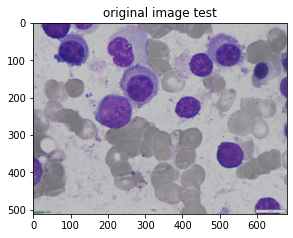

In [35]:
#TEST IMAGES
n = 60
test_i = X_test[n-1,:,:,:]
#test_m = Y_test[n-1,:,:,:]

fig = plt.figure(figsize=(10,40))
ax = fig.add_subplot(1,2,1)
ax.imshow(test_i), ax.set_title('original image test')

# ax = fig.add_subplot(1,2,2)
# ax.imshow(test_m), ax.set_title('manual mask test')

Risultati preprocessing

In [36]:
n = 58

test_i = X_test[n-1,:,:]
test_p = X_test_processed[n-1,:,:,:]

ax1 = fig.add_subplot(1,6,5)
im1 = ax1.imshow(test_i,cmap=plt.cm.gray), ax1.set_title('test image')

ax1 = fig.add_subplot(1,6,6)
im1 = ax1.imshow(test_p,cmap=plt.cm.gray), ax1.set_title('test image processed')   

Visualizzazione maschere

(<matplotlib.image.AxesImage at 0x7f1f91b02910>, Text(0.5, 1.0, 'output 3'))

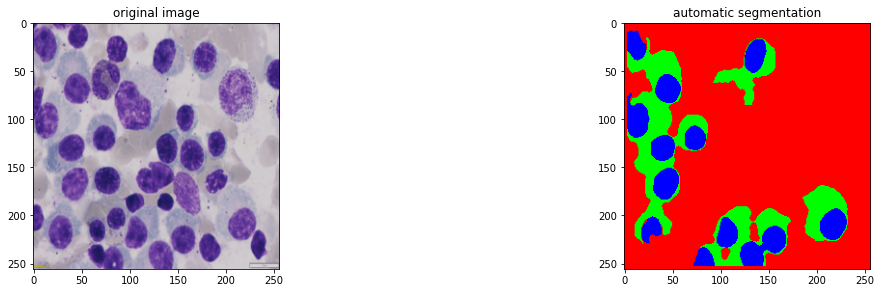

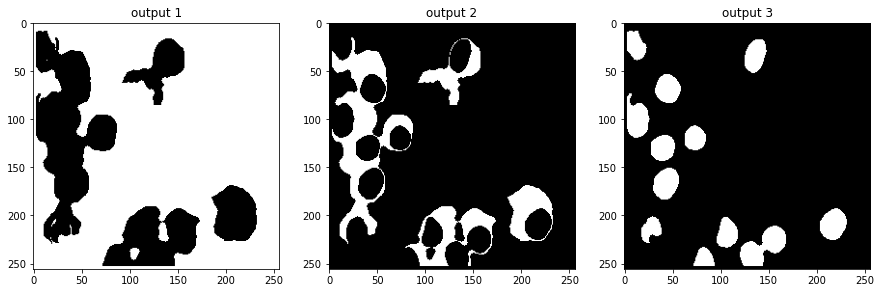

In [37]:
n = 67

fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1,3,1)
ax1.imshow(X_test_processed[n-1,:,:,:],cmap=plt.cm.gray), ax1.set_title('original image')
#ax2 = plt.subplot(1,3,2)
#ax2.imshow(Y_test_processed[n-1,:,:,:],cmap=plt.cm.gray), ax2.set_title('manual segmentation')    
ax3 = plt.subplot(1,3,3)
ax3.imshow(mask_auto_test[n-1,:,:,:]), ax3.set_title('automatic segmentation')

mask_auto1 = mask_auto_test[n-1,:,:,0]
mask_auto2 = mask_auto_test[n-1,:,:,1]
mask_auto3 = mask_auto_test[n-1,:,:,2]

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(mask_auto1,cmap=plt.cm.gray), ax1.set_title('output 1')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(mask_auto2,cmap=plt.cm.gray), ax2.set_title('output 2')    
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(mask_auto3,cmap=plt.cm.gray), ax3.set_title('output 3') 

# IoUmean_t = IoUval_test[n-1]
# print(f"Valore IoU della maschera {n} :{IoUmean[1:4]}") 

Risultato watershed

Text(0.5, 1.0, 'watershed segmentation')

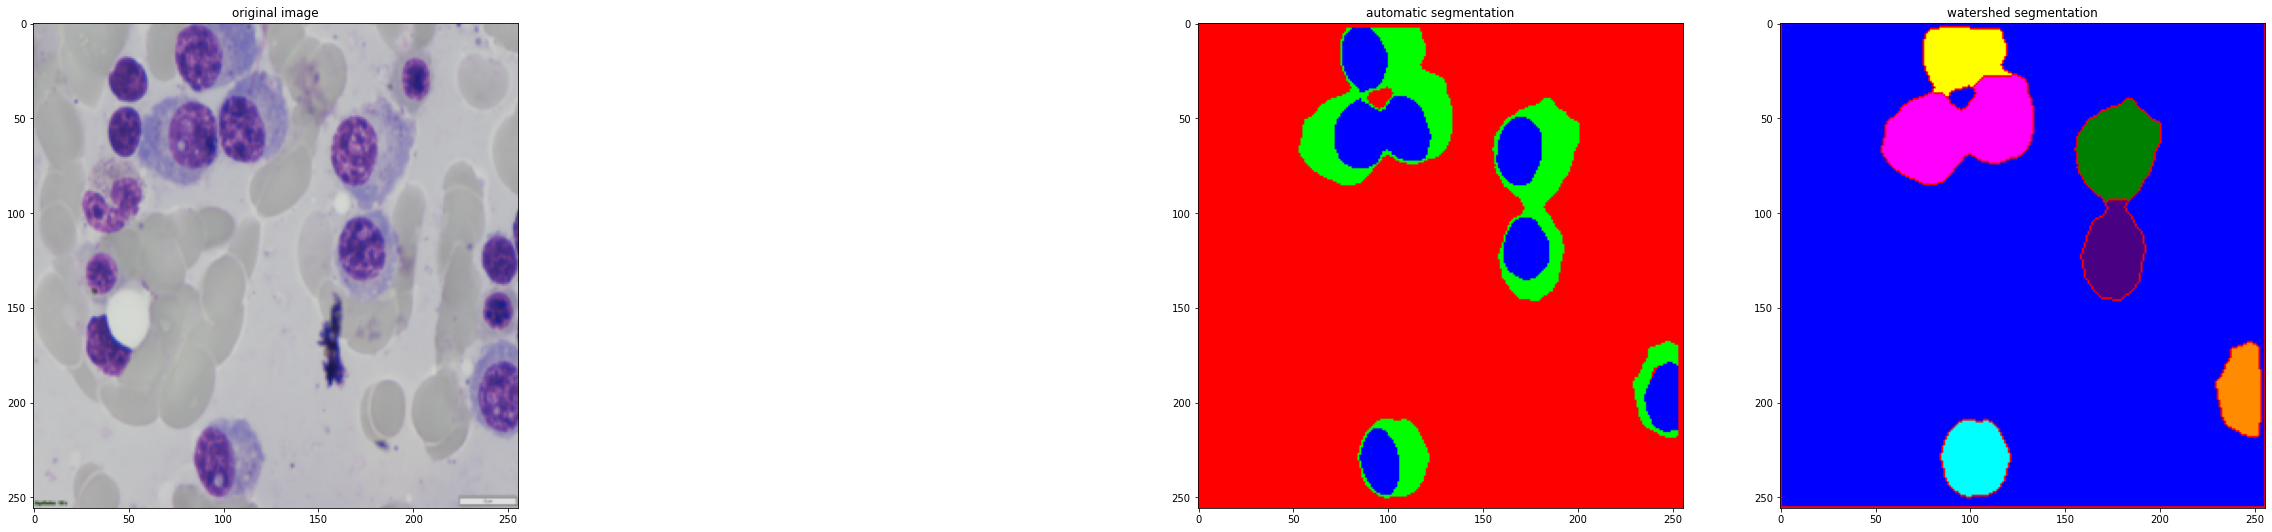

In [38]:
#TEST
n=6
fig = plt.figure(figsize=(40,20))
ax0 = fig.add_subplot(1,4,1)
ax0.imshow(X_test_processed[n-1,:,:,:],cmap=plt.cm.gray), ax0.set_title('original image')
# ax1 = fig.add_subplot(1,4,2)
# ax1.imshow(Y_val_processed[n-1,:,:,:],cmap=plt.cm.gray), ax1.set_title('manual segmentation')
ax2 = plt.subplot(1,4,3)
ax2.imshow(mask_auto_test[n-1,:,:,:],cmap=plt.cm.gray)
ax2.set_title('automatic segmentation')
ax3 = plt.subplot(1,4,4)
ax3.imshow(color.label2rgb(markers_cells_test, bg_label=0)[n-1,:,:],cmap=plt.cm.gray)
ax3.set_title('watershed segmentation')

esempio di output della funzione mask_to_grayscale e divisione cellule


sono state trovate 12 cellule nell'immagine 7 del test set


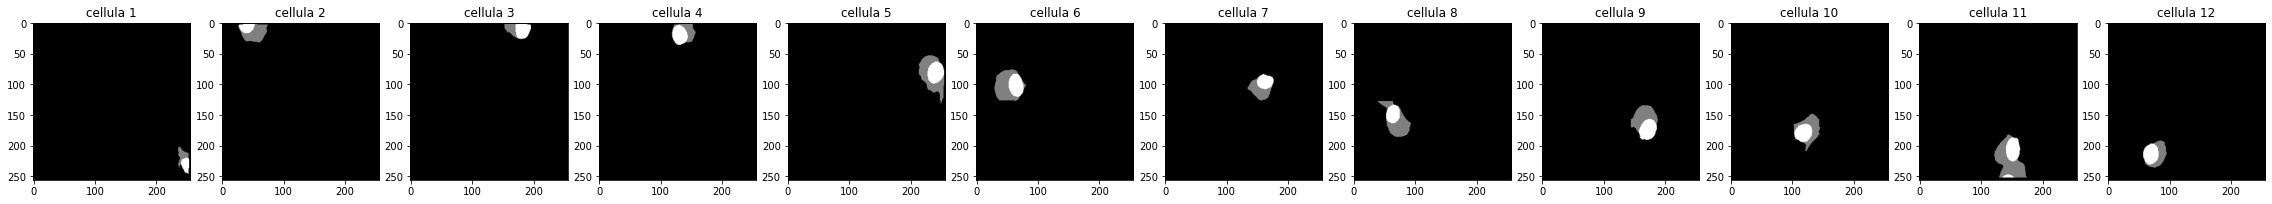

In [39]:
#TEST
n=7
mask_temp = mask_cell_greyscale_test[n-1]

fig = plt.figure(figsize=(40,20))

print(f"sono state trovate {mask_temp.shape[2]} cellule nell'immagine {n} del test set")
for i in range(mask_temp.shape[2]):
  ax = fig.add_subplot(1,mask_temp.shape[2],i+1)
  ax.imshow(mask_temp[:,:,i-1],cmap=plt.cm.gray), ax.set_title(f"cellula {i+1}")

del mask_temp